In [28]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

os.makedirs('images', exist_ok=True)
os.makedirs('saved_models', exist_ok=True)

channels = 1
img_size = 28
n_classes = 10
latent_dim = 100
batch_size = 32
learning_rate = .0002
b1 = .5
b2 = .999
sample_interval = 400
n_epochs = 2
img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [  nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim+n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img
    
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)
        
        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1)
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity
    
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

# Loss functions
adversarial_loss = torch.nn.MSELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

In [3]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row**2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([1 for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, 'images/%d.png' % batches_done, nrow=n_row, normalize=True)
    

def save_image()

In [18]:
classes = ['saxophone',
            'raccoon',
            'piano',
            'panda',
            'leg',
            'headphones',
            'ceiling_fan',
            'bed',
            'basket',
            'aircraft_carrier']
    
class QuickDrawDataset(Dataset):
    """Quick Draw dataset."""

    def __init__(self, label, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = self.get_all_classes(1000)
        self.label = label
        self.transform = transform
    
    def get_all_classes(self, sample_per_class=100):
        all_classes = []
        for i, label in enumerate(classes):
            img = np.apply_along_axis(self.__reshape_row, 1, np.load('../data/%s.npy' % label))
            all_classes.extend([(row, i) for row in img[np.random.choice(len(img), sample_per_class)]])
        return all_classes
    
    def __reshape_row(self, row):
        return np.reshape(row, (28, 28))
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        image = self.data_frame[idx][0]
        label = self.data_frame[idx][1]
        return image, label

In [19]:
data = QuickDrawDataset(label='panda', transform=transforms.Compose([
                        transforms.Resize(img_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
dataloader = DataLoader(data, batch_size=32, shuffle=False)

[Epoch 0/1] [Batch 0/313] [D loss: 26.027779] [G loss: 1.033194]
[Epoch 0/1] [Batch 1/313] [D loss: 11.412572] [G loss: 1.035743]
[Epoch 0/1] [Batch 2/313] [D loss: 15.312386] [G loss: 1.040489]
[Epoch 0/1] [Batch 3/313] [D loss: 11.950084] [G loss: 1.035176]
[Epoch 0/1] [Batch 4/313] [D loss: 16.428133] [G loss: 1.033281]
[Epoch 0/1] [Batch 5/313] [D loss: 19.813412] [G loss: 1.046757]
[Epoch 0/1] [Batch 6/313] [D loss: 24.196918] [G loss: 1.036465]
[Epoch 0/1] [Batch 7/313] [D loss: 11.250469] [G loss: 1.040988]
[Epoch 0/1] [Batch 8/313] [D loss: 10.368031] [G loss: 1.047000]
[Epoch 0/1] [Batch 9/313] [D loss: 18.838497] [G loss: 1.043866]
[Epoch 0/1] [Batch 10/313] [D loss: 13.280270] [G loss: 1.039758]
[Epoch 0/1] [Batch 11/313] [D loss: 14.582309] [G loss: 1.036922]
[Epoch 0/1] [Batch 12/313] [D loss: 13.275769] [G loss: 1.042121]
[Epoch 0/1] [Batch 13/313] [D loss: 14.544820] [G loss: 1.031550]
[Epoch 0/1] [Batch 14/313] [D loss: 25.511530] [G loss: 1.035457]
[Epoch 0/1] [Batch 1

[Epoch 0/1] [Batch 127/313] [D loss: 10.988154] [G loss: 1.039900]
[Epoch 0/1] [Batch 128/313] [D loss: 8.823195] [G loss: 1.034068]
[Epoch 0/1] [Batch 129/313] [D loss: 7.729195] [G loss: 1.040521]
[Epoch 0/1] [Batch 130/313] [D loss: 8.649550] [G loss: 1.035308]
[Epoch 0/1] [Batch 131/313] [D loss: 12.775069] [G loss: 1.039873]
[Epoch 0/1] [Batch 132/313] [D loss: 9.249232] [G loss: 1.029906]
[Epoch 0/1] [Batch 133/313] [D loss: 8.919064] [G loss: 1.027646]
[Epoch 0/1] [Batch 134/313] [D loss: 10.697927] [G loss: 1.037428]
[Epoch 0/1] [Batch 135/313] [D loss: 9.310973] [G loss: 1.041467]
[Epoch 0/1] [Batch 136/313] [D loss: 7.430064] [G loss: 1.035313]
[Epoch 0/1] [Batch 137/313] [D loss: 6.564551] [G loss: 1.037226]
[Epoch 0/1] [Batch 138/313] [D loss: 13.219500] [G loss: 1.036337]
[Epoch 0/1] [Batch 139/313] [D loss: 14.457786] [G loss: 1.033307]
[Epoch 0/1] [Batch 140/313] [D loss: 9.127892] [G loss: 1.038392]
[Epoch 0/1] [Batch 141/313] [D loss: 7.764158] [G loss: 1.037621]
[Epoc

[Epoch 0/1] [Batch 250/313] [D loss: 29.076033] [G loss: 1.036564]
[Epoch 0/1] [Batch 251/313] [D loss: 46.560345] [G loss: 1.034472]
[Epoch 0/1] [Batch 252/313] [D loss: 50.194115] [G loss: 1.037705]
[Epoch 0/1] [Batch 253/313] [D loss: 39.501266] [G loss: 1.034557]
[Epoch 0/1] [Batch 254/313] [D loss: 30.064569] [G loss: 1.038430]
[Epoch 0/1] [Batch 255/313] [D loss: 32.607117] [G loss: 1.041926]
[Epoch 0/1] [Batch 256/313] [D loss: 30.807510] [G loss: 1.029407]
[Epoch 0/1] [Batch 257/313] [D loss: 26.470297] [G loss: 1.038182]
[Epoch 0/1] [Batch 258/313] [D loss: 20.790216] [G loss: 1.027677]
[Epoch 0/1] [Batch 259/313] [D loss: 14.431027] [G loss: 1.035165]
[Epoch 0/1] [Batch 260/313] [D loss: 27.175949] [G loss: 1.041269]
[Epoch 0/1] [Batch 261/313] [D loss: 37.240044] [G loss: 1.040972]
[Epoch 0/1] [Batch 262/313] [D loss: 16.693903] [G loss: 1.032822]
[Epoch 0/1] [Batch 263/313] [D loss: 27.119736] [G loss: 1.034281]
[Epoch 0/1] [Batch 264/313] [D loss: 24.597044] [G loss: 1.034

[Epoch 1/1] [Batch 62/313] [D loss: 22.235720] [G loss: 1.038053]
[Epoch 1/1] [Batch 63/313] [D loss: 25.848986] [G loss: 1.035580]
[Epoch 1/1] [Batch 64/313] [D loss: 17.292515] [G loss: 1.032987]
[Epoch 1/1] [Batch 65/313] [D loss: 31.837404] [G loss: 1.036259]
[Epoch 1/1] [Batch 66/313] [D loss: 34.864513] [G loss: 1.035274]
[Epoch 1/1] [Batch 67/313] [D loss: 36.921642] [G loss: 1.031770]
[Epoch 1/1] [Batch 68/313] [D loss: 36.662861] [G loss: 1.035899]
[Epoch 1/1] [Batch 69/313] [D loss: 35.850815] [G loss: 1.036577]
[Epoch 1/1] [Batch 70/313] [D loss: 26.911283] [G loss: 1.040536]
[Epoch 1/1] [Batch 71/313] [D loss: 22.123636] [G loss: 1.036668]
[Epoch 1/1] [Batch 72/313] [D loss: 38.415440] [G loss: 1.040607]
[Epoch 1/1] [Batch 73/313] [D loss: 18.656736] [G loss: 1.042263]
[Epoch 1/1] [Batch 74/313] [D loss: 33.691460] [G loss: 1.040381]
[Epoch 1/1] [Batch 75/313] [D loss: 33.260860] [G loss: 1.030795]
[Epoch 1/1] [Batch 76/313] [D loss: 36.024357] [G loss: 1.033440]
[Epoch 1/1

[Epoch 1/1] [Batch 189/313] [D loss: 24.678617] [G loss: 1.041474]
[Epoch 1/1] [Batch 190/313] [D loss: 12.907020] [G loss: 1.035527]
[Epoch 1/1] [Batch 191/313] [D loss: 15.127314] [G loss: 1.037707]
[Epoch 1/1] [Batch 192/313] [D loss: 21.518711] [G loss: 1.036219]
[Epoch 1/1] [Batch 193/313] [D loss: 18.253338] [G loss: 1.039843]
[Epoch 1/1] [Batch 194/313] [D loss: 31.421421] [G loss: 1.038030]
[Epoch 1/1] [Batch 195/313] [D loss: 24.601469] [G loss: 1.041583]
[Epoch 1/1] [Batch 196/313] [D loss: 21.597473] [G loss: 1.029641]
[Epoch 1/1] [Batch 197/313] [D loss: 14.325696] [G loss: 1.031867]
[Epoch 1/1] [Batch 198/313] [D loss: 17.182377] [G loss: 1.036096]
[Epoch 1/1] [Batch 199/313] [D loss: 17.502245] [G loss: 1.039093]
[Epoch 1/1] [Batch 200/313] [D loss: 18.564356] [G loss: 1.040767]
[Epoch 1/1] [Batch 201/313] [D loss: 15.147091] [G loss: 1.036716]
[Epoch 1/1] [Batch 202/313] [D loss: 14.025780] [G loss: 1.039233]
[Epoch 1/1] [Batch 203/313] [D loss: 17.772659] [G loss: 1.038

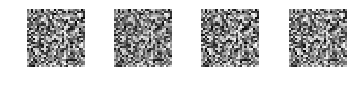

In [45]:
training_gen_loss = []
training_dis_loss = []

for epoch in range(n_epochs):
    mean_dis_loss = []
    mean_gen_loss = []
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = len(imgs)
        
        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.array([1]*batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)
        
        
        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        mean_dis_loss.append(d_loss.item())
        mean_gen_loss.append(g_loss.item())
        
        print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, 1, i, len(dataloader),
                                                            d_loss.item(), g_loss.item()))
    
        batches_done = epoch * len(dataloader) + i
        if epoch % 50 == 0 and batches_done % sample_interval == 0:
            plt.figure(figsize=(5,5))
            for k in range(4):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs.detach().numpy()[k][0], cmap='gray')
                plt.axis('off')
            plt.tight_layout()
            plt.savefig('./images/epoch_{}_{}.png'.format(epoch+1, batches_done))
        
    training_gen_loss.append(np.mean(mean_dis_loss))
    training_dis_loss.append(np.mean(mean_gen_loss))

In [54]:
def save_model():
    torch.save({
            'epoch': n_epochs,
            'generator': generator.model.state_dict(),
            'discriminator': discriminator.model.state_dict(),
            'optimizer_gen': optimizer_G.state_dict(),
            'optimizer_dis': optimizer_D.state_dict(),
            'G_loss': training_gen_loss,
            'D_loss': training_dis_loss
            }, 'saved_models/models')

In [47]:
classes = ['saxophone',
        'raccoon',
        'piano',
        'panda',
        'leg',
        'headphones',
        'ceiling_fan',
        'bed',
        'basket',
        'aircraft_carrier']

def reshape_row(row):
    return np.reshape(row, img_shape)

all_classes = []
for label in classes:
    img = np.apply_along_axis(reshape_row, 1, np.load('../data/%s.npy' % label))
    all_classes.extend([(row, label) for row in img[np.random.choice(len(img), 10)]])

data = np.array(all_classes)

saxophone


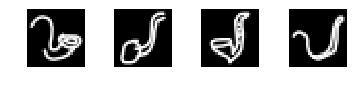

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
for k in range(4):
    plt.subplot(4, 4, k+1)
    plt.imshow(all_classes[k][0].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.savefig('./images/2.png'.format(epoch+1))
print(all_classes[1][1])

In [48]:
data.shape

(100, 2)

In [53]:
data[np.random.choice(data.shape[0],32,replace=False)]

ValueError: Cannot take a larger sample than population when 'replace=False'

In [59]:
data.shape[0]

100

In [61]:
np.load('../data/panda.npy')[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)